# 演習その2 音声信号を特徴量に変換する

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import read
from librosa.filters import mel as librosa_mel_fn
import IPython.display

In [2]:
MAX_WAV_VALUE = 32768.0

In [3]:
def load_wav(full_path):
    sampling_rate, data = read(full_path)
    return data, sampling_rate


def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)


def dynamic_range_decompression(x, C=1):
    return np.exp(x) / C


def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)


def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C


def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output


def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output

In [4]:
n_fft=1024
n_mels=80
hop_length=256
win_length=1024
fmin=0.
fmax=8000
center=False

filename = "resources/sample/84-121123-0000.wav"

In [5]:
IPython.display.Audio(filename)

# 1.音声波形の表示

In [6]:
audio, sampling_rate = load_wav(filename)
num_samples = len(audio)
audio = audio / MAX_WAV_VALUE
audio = torch.FloatTensor(audio)
audio = audio.unsqueeze(0)
audio = torch.nn.functional.pad(audio.unsqueeze(1), (int((n_fft-hop_length)/2), int((n_fft-hop_length)/2)), mode='reflect')
audio = audio.squeeze(1)
print("sampling_rate=", sampling_rate)
print("num_samples=", num_samples)

sampling_rate= 16000
num_samples= 33440


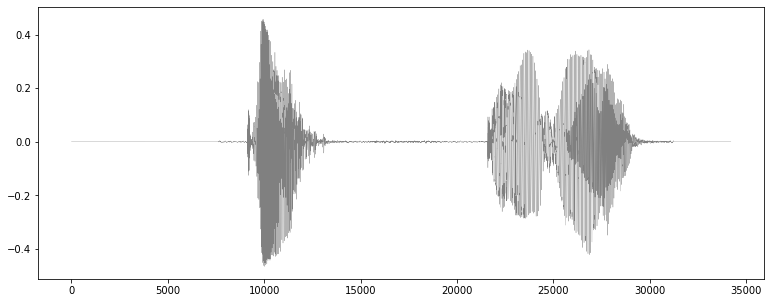

In [7]:
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(111)
ax.plot(audio[0], lw=0.3, color="gray")

# 2.スペクトログラムの表示

In [8]:
mel_basis = {}
hann_window = {}
if fmax not in mel_basis:
    mel = librosa_mel_fn(sampling_rate, n_fft, n_mels, fmin, fmax)
    mel_basis[str(fmax)+'_'+str(audio.device)] = torch.from_numpy(mel).float().to(audio.device)
    hann_window[str(audio.device)] = torch.hann_window(win_length).to(audio.device)

In [9]:
spec = torch.stft(audio, n_fft, hop_length=hop_length, win_length=win_length, window=hann_window[str(audio.device)],
                  center=center, pad_mode='reflect', normalized=False, onesided=True)

/opt/conda/lib/python3.8/site-packages/torch/functional.py:695: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/SpectralOps.cpp:795.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


Text(0.5, 1.0, 'Spectrogram')

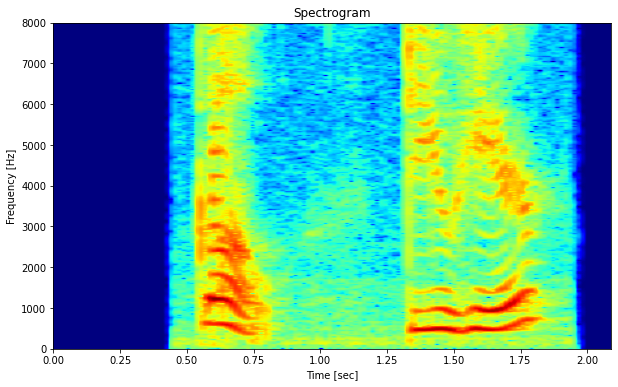

In [10]:
spectrogram = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))
spectrogram = spectral_normalize_torch(spectrogram[0]).numpy()
spectrogram -= np.max(spectrogram)
vmax = np.abs(np.min(spectrogram)) * 0.0
vmin = -np.abs(np.min(spectrogram)) * 1

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.imshow(spectrogram[-1::-1,:],
           extent=[0, num_samples/sampling_rate, 0, sampling_rate],
           cmap="jet", vmax=vmax, vmin=vmin, aspect="auto")
ax.set_ylim(0,8000)
ax.set_xlabel("Time [sec]")
ax.set_ylabel("Frequency [Hz]")
ax.set_title("Spectrogram")

# 3.メルスペクトログラムの表示

## 3.1 メルフィルタバンクの生成

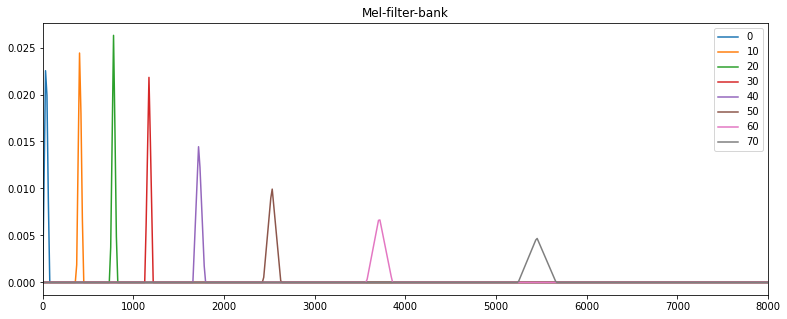

In [18]:
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(111)
x = np.linspace(0, fmax, 513)
for i in range(0,80,10):
    ax.plot(x, mel_basis[str(fmax)+'_'+str(audio.device)][i], label=str(i))
ax.set_xlim(0, fmax)
ax.set_title("Mel-filter-bank")
ax.legend()

## 3.2 メルスペクトログラム計算

Text(0.5, 1.0, 'Mel-spectrogram')

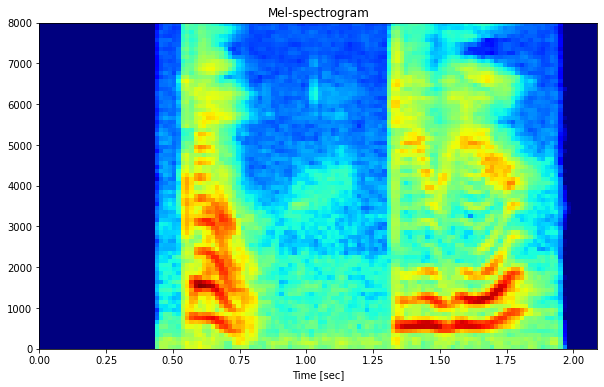

In [12]:
mel_spectrogram = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))
mel_spectrogram = torch.matmul(mel_basis[str(fmax)+'_'+str(audio.device)], mel_spectrogram)
mel_spectrogram = spectral_normalize_torch(mel_spectrogram)
mel_spectrogram = mel_spectrogram.numpy()

mel_spectrogram -= np.max(mel_spectrogram)
vmax = np.abs(np.min(mel_spectrogram)) * 0.0
vmin = -np.abs(np.min(mel_spectrogram)) * 1

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.imshow(mel_spectrogram[0][-1::-1,:],
    extent=[0, num_samples/sampling_rate, 0, fmax],
    cmap="jet", vmax=vmax, vmin=vmin, aspect="auto")
ax.set_xlabel("Time [sec]")
ax.set_title("Mel-spectrogram")